# Primary Productivity and Export

This analysis goes through the relationship between Primary Production, Export, Flux attenuation, Commununity Composition and the vertical structure of the upper ocean

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0, '../src/')
import PrimaryProductionTools as ppt
from ExportTools import martins_curve_log, fit_export_events


In [2]:
black=(0,0,0)
lightblue= (112/255.0,160/255.0,205/255.0)
orange=(196/255.0,121/255.0,0)
grey=(178/255.0,178/255.0,178/255.0)
darkblue=(0,52/255.0,102/255.0)
darkgreen=(0,79/255.,0)

black_shade = (128/255.0,128/255.0, 128/255.0)
lightblue_shade = (91/255.0, 174/255.0,178/255.0)
orange_shade = (204/255.0,174/255.0,113/255.0)
grey_shade = (191/255.0,191/255.0,191/255.0)
darkblue_shade = (67/255.0,147/255.0,195/255.0)
darkgreen_shade =(223/255.0, 237/255.0,195/255.0)

cmap = plt.cm.get_cmap("Spectral_r", 64)


In [3]:
def brunt_vaisala(salt, temp, pres, lat=None):
        r"""
        Calculate the square of the buoyancy frequency.

        This is a copy from GSW package, with the exception that
        the array maintains the same shape as the input. Note that
        it only works on ungridded data at the moment.

        .. math::

        N^{2} = \frac{-g}{\sigma_{\theta}} \frac{d\sigma_{\theta}}{dz}

        Parameters
        ----------
        SA : array-like
            Absolute Salinity, g/kg
        CT : array-like
            Conservative Temperature (ITS-90), degrees C
        p : array-like
            Sea pressure (absolute pressure minus 10.1325 dbar), dbar
        lat : array-like, 1-D, optional
            Latitude, degrees.
        axis : int, optional
            The dimension along which pressure increases.

        Returns
        -------
        N2 : array
            Buoyancy frequency-squared at pressure midpoints, 1/s.
            The shape along the pressure axis dimension is one
            less than that of the inputs.
        """

        from gsw import Nsquared
        from numpy import nan, r_

        def pad_nan(a):
            return r_[a, nan]

        n2 = pad_nan(Nsquared(salt, temp, pres)[0])

        return n2

# Export Rates

Note this is a repeat of 


 - Searches for coherent sinking events  
 - Computes sinking rate from these by fitting a linear regression
 - Fits Martins curve power law to derive particle attenuation rates
 - Computes the Aggregate POC flux based on a bulk sinking rate 

# Load data

Data is binned to 10m in the vertical and 2 days in the horizontal.  
A 50 meter rolling mean and a 2 day rolling mean is then applied

In [4]:
ds_643 = xr.open_dataset('../data/seaglider/sg643/sg643_optics_v16042021-v2.nc')

custom_bin = np.r_[
    np.arange(0, 400, 10),
   ]
dive_time=ppt.time_average_per_dive(ds_643.dives,ds_643.time)
time643=np.unique(dive_time)
x=ds_643.dives
y=ds_643.depth
lat_grd=ppt.pandas_grid(ds_643.latitude,dive_time,ds_643.depth,bins=custom_bin)
lon_grd=ppt.pandas_grid(ds_643.longitude,dive_time,ds_643.depth,bins=custom_bin)


spike_grd=ppt.pandas_grid(ds_643.bbp700_spikes,dive_time,ds_643.depth,bins=custom_bin)
spike_resample=spike_grd.transpose().resample('2D').mean()
spike_running = spike_resample.rolling('2D').mean().transpose().rolling(5).mean()


In [5]:
ds_640 = xr.open_dataset('../data/seaglider/sg640/sg640_opticsv16042021.nc')
x=ds_640.time
y=ds_640.depth
custom_bin = np.r_[
    np.arange(0, 400, 10),
   ]
dive_time=ppt.time_average_per_dive(ds_640.dives,ds_640.time)
time640=np.unique(dive_time)

lat_grd=ppt.pandas_grid(ds_640.latitude,dive_time,ds_640.depth,bins=custom_bin)
lon_grd=ppt.pandas_grid(ds_640.longitude,dive_time,ds_640.depth,bins=custom_bin)



baseline_grd=ppt.pandas_grid(ds_640.bbp_baseline,dive_time,ds_640.depth,bins=custom_bin)
spike_grd=ppt.pandas_grid(ds_640.bbp_spikes,dive_time,ds_640.depth,bins=custom_bin)
# baseline_resample=baseline_grd.transpose().resample('2D').mean()
spike_resample=spike_grd.transpose().resample('2D').mean()
spike_running640 = spike_resample.rolling('2D').mean().transpose().rolling(5).mean()
# baseline_running640 = baseline_resample.rolling('2D').mean().transpose().rolling(2).mean()



# Fit export events

(-1.0, 45.0)

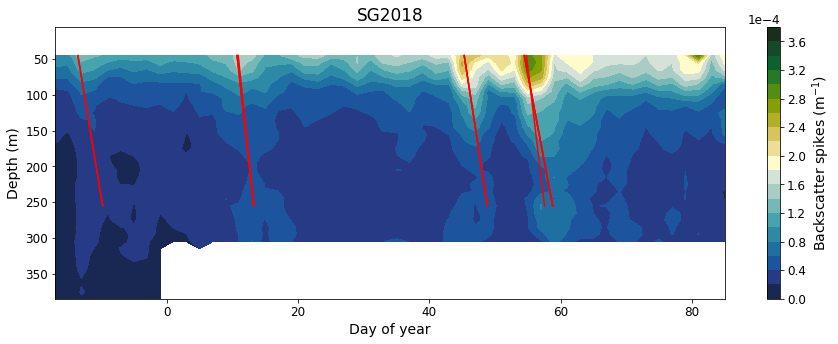

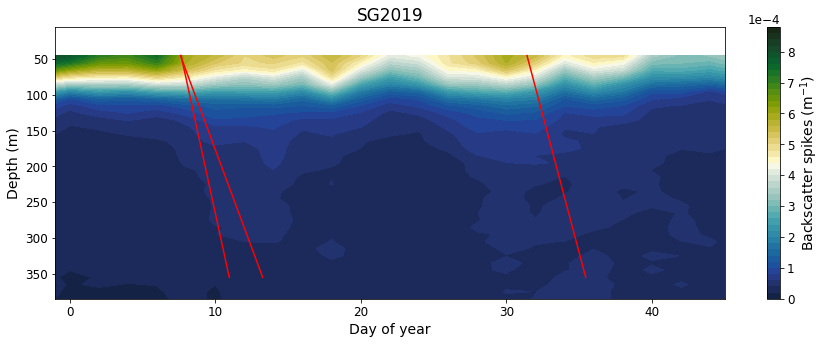

In [6]:
df643,dfR643,ax643=fit_export_events(spike_running, glider_id='SG2018',moving_window=5,
                             min_depth=50,max_depth=270,  r2_threshold=0.4,output_figure=True,levels=np.arange(0,4e-4,2e-5))
ax1=ax643.gca()
ax1.set_title('SG2018')
df640,dfR640,ax640=fit_export_events(spike_running640, glider_id='SG2019',moving_window=5,
                                   min_depth=50,max_depth=370, r2_threshold=0.4,output_figure=True,levels=np.arange(0,9e-4,2e-5))
ax=ax640.gca()
ax.set_title('SG2019')

ax.set_xlim(-1,45)


In [7]:
df643.sinking_rate[:].max()-df643.sinking_rate[:].min()

39.89615384615381

In [8]:
df643.sinking_rate[:].mean()

65.2414281219578

In [9]:
df640.sinking_rate[3:].mean()

65.86720321931591

In [10]:
df640.sinking_rate[:].max()-df640.sinking_rate[:].min()

54.774275895925356

# Convert backscatter to POC

In [11]:
# 643
aggPOC = np.ndarray([len(spike_running.columns),len(spike_running.index)])
for i in range(len(spike_running.index)): 
    aggPOC[:,i] = ((spike_running.iloc[i,:])
                    *35400*(spike_running.index[i]/100)**-0.28)
    
aggPOC_643=xr.DataArray(data=aggPOC.T,dims={'index','columns'},
             coords=[('index',spike_running.index.values),('columns',spike_running.columns.values)]).to_pandas()

In [12]:
# 640
aggPOC_640 = np.ndarray([len(spike_running640.columns),len(spike_running640.index)])
for i in range(len(spike_running640.index)): 
    aggPOC_640[:,i] = ((spike_running640.iloc[i,:])
                    *35400*(spike_running640.index[i]/100)**-0.28)

aggPOC_640=xr.DataArray(data=aggPOC_640.T,dims={'index','columns'},
             coords=[('index',spike_running640.index.values),('columns',spike_running640.columns.values)]).to_pandas()
    

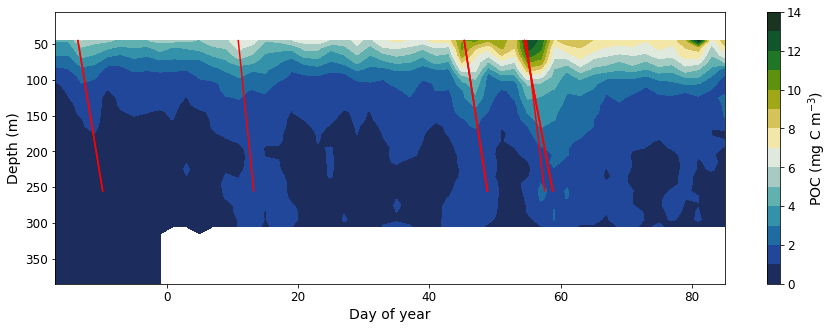

In [13]:
# Recompute flux events based on POC

df643_poc,dfR643_poc,fig=fit_export_events(aggPOC_643, glider_id='SG2018_poc',moving_window=5,
                                           min_depth=50,max_depth=270,  r2_threshold=0.5,output_figure=True,
                                           cbar_label='POC (mg C m$^{-3}$)',
                                           sci_notation=False,levels=np.arange(0,15,1))

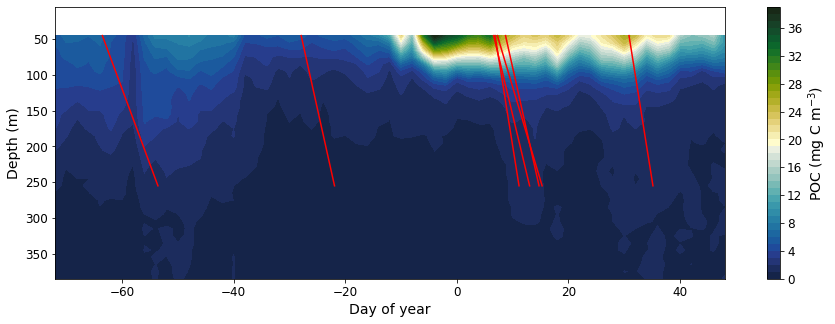

In [14]:
df640_poc,dfR640_poc,fig=fit_export_events(aggPOC_640, glider_id='SG2019_poc',moving_window=5,
                                           min_depth=50,max_depth=270, r2_threshold=0.4,
                                           cbar_label='POC (mg C m$^{-3}$)',
                                           sci_notation=False,output_figure=True,levels=np.arange(0,40,1))

In [15]:
# load derived data: Export and Primary Productivity

## Export
sg643 = xr.open_dataset('../results/data/export643.nc')
sg640= xr.open_dataset('../results/data/export640.nc')

## Primary Productivity 
npp643=xr.open_dataset('../results/data/npp_643.nc')
npp640=xr.open_dataset('../results/data/npp_640.nc')



In [16]:
# load glider files to determine N2

## 
ds_643 = xr.open_dataset('../data/seaglider/sg643/sg643_optics_v16042021-v2.nc')

custom_bin = np.r_[
    np.arange(0, 400, 2),
   ]

dive_time=ppt.time_average_per_dive(ds_643.dives,ds_643.time)
time643=np.unique(dive_time)
x=ds_643.dives
y=ds_643.depth
lat_grd=ppt.pandas_grid(ds_643.latitude,dive_time,ds_643.depth,bins=custom_bin)
lon_grd=ppt.pandas_grid(ds_643.longitude,dive_time,ds_643.depth,bins=custom_bin)

n2_643 = brunt_vaisala(ds_643.salinity.rolling(ctd_data_point=3).mean(),ds_643.temperature.rolling(ctd_data_point=3).mean(),
                       ds_643.depth.rolling(ctd_data_point=3).mean(),)

mld_smooth643= ppt.mixed_layer_depth(x,y, ds_643.rho, thresh=0.03, return_as_mask=False).rolling(10,min_periods=3).mean()

n2_z643 = ppt.pandas_grid(n2_643,ds_643.dives,ds_643.depth,bins=custom_bin)
ct_z643 = ppt.pandas_grid(ds_643.temperature,ds_643.dives,ds_643.depth,bins=custom_bin)
rho_z643 = ppt.pandas_grid(ds_643.rho,ds_643.dives,ds_643.depth,bins=custom_bin)



##################################

ds_640 = xr.open_dataset('../data/seaglider/sg640/sg640_opticsv16042021.nc')
x=ds_640.dives
y=ds_640.depth
dive_time=ppt.time_average_per_dive(ds_640.dives,ds_640.time)
time640 = np.unique(dive_time)

lat_grd640=ppt.pandas_grid(ds_640.latitude,dive_time,ds_640.depth,bins=custom_bin)
lon_grd640=ppt.pandas_grid(ds_640.longitude,dive_time,ds_640.depth,bins=custom_bin)


mld_smooth640= ppt.mixed_layer_depth(x,y, ds_640.rho, thresh=0.03, return_as_mask=False).rolling(10,min_periods=3).mean()


n2_640 = brunt_vaisala(ds_640.salinity.rolling(ctd_data_point=3).mean(),ds_640.temperature.rolling(ctd_data_point=3).mean(),
                       ds_640.depth.rolling(ctd_data_point=3).mean(),)


n2_z640 = ppt.pandas_grid(n2_640,ds_640.dives,ds_640.depth,bins=custom_bin)
ct_z640 = ppt.pandas_grid(ds_640.temperature,ds_640.dives,ds_640.depth,bins=custom_bin)
rho_z640 = ppt.pandas_grid(ds_640.rho,ds_640.dives,ds_640.depth,bins=custom_bin)



### Have a look at the average density profiles

(400.0, 0.0)

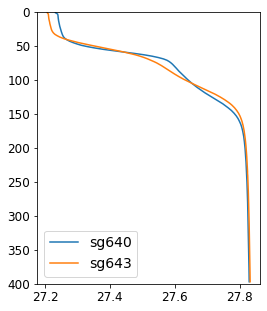

In [17]:
plt.figure(figsize=[4,5])
plt.plot(np.mean(rho_z640.iloc[:,670:],1)-1000,rho_z640.index,label='sg640')
plt.plot(np.mean(rho_z643,1)-1000,rho_z640.index,label='sg643')

plt.legend()
plt.ylim(400,0)

## Compute depth of max strat and second strat layer

In [18]:
# SG643
n2_max643=np.ndarray(len(n2_z643.iloc[1,:]))
n2_max643_value=np.ndarray(len(n2_z643.iloc[1,:]))
n2_second_max643 = np.ndarray(len(n2_z643.iloc[1,:]))
n2_second_max643_value = np.ndarray(len(n2_z643.iloc[1,:]))

for i in range(len(n2_z643.iloc[1,:])):
        indmax=n2_z643.iloc[:,i].argmax()# n2_z640
        
        n2_max643[i] = (custom_bin[indmax])
        n2_max643_value[i]=n2_z643.iloc[indmax,i]
        # mask values above n2max
        n2_second = n2_z643[n2_z643.index>n2_max643[i]+20].interpolate(lim=10)

        if n2_second.empty:
            indmax2 = 0
        else:
            indmax2 = n2_second.iloc[:,i].argmax()
            indmax2 = indmax2+indmax
        
        n2_second_max643[i]=custom_bin[indmax2]
        n2_second_max643_value[i] =  n2_z643.iloc[indmax2,i]

        
        if n2_max643[i]> n2_second_max643[i]:
            n2_max643[i]=n2_max643[i-1]

            
n2_max643[n2_max643>300]=np.nan
n2_max643=pd.Series(n2_max643).rolling(5).mean()
n2_second_max643=pd.Series(n2_second_max643).rolling(5).mean()
n2_second_max643_value = pd.Series(n2_second_max643_value).rolling(5).mean()
n2_max643_value=pd.Series(n2_max643_value).rolling(5).mean()

In [19]:
#SG640
n2_max=np.ndarray(1114)
n2_max_value = np.ndarray(1114)
n2_second_max = np.ndarray(1114)
n2_second_max_value = np.ndarray(1114)

for i in range(len(n2_z640.iloc[1,:])):
        indmax=n2_z640.iloc[:,i].argmax()# n2_z640
    
        n2_max[i] = (custom_bin[indmax])
        n2_max_value[i] = n2_z640.iloc[indmax,i]
        # mask values above n2max
        n2_second = n2_z640[n2_z640.index>n2_max[i]+20].interpolate(lim=10)

        if n2_second.empty:

            indmax2 = 0
        else:
            indmax2 = n2_second.iloc[:,i].argmax()
            indmax2 = indmax2+indmax
        
        
        n2_second_max[i]=custom_bin[indmax2]
        n2_second_max_value[i] =  n2_z640.iloc[indmax2,i]

n2_max=pd.Series(n2_max).rolling(5).mean()
n2_second_max=pd.Series(n2_second_max).rolling(5).mean()
n2_second_max_value=pd.Series(n2_second_max_value).rolling(5).mean()


In [20]:
n2_second_max_value=pd.Series(n2_second_max_value).rolling(5).mean()

In [21]:
n2_second_max.std()

47.17061993082003

In [22]:
n2_second_max643.std()

14.461051143939512

In [23]:
mld_smooth640.std()

23.17875879840247

In [24]:
mld_smooth643.std()

9.088358074583196

## Compute community Index

In [25]:
#SG643

df643_atten = pd.read_csv('../results/data/chlC643_mld.csv')
df643_atten.index=pd.to_datetime(df643_atten.time)
df643_atten['chl2carbon']=df643_atten.chl/df643_atten.carbon
df643_atten=df643_atten.resample('2D').mean().rolling('2D').mean()

#SG640

df640_atten = pd.read_csv('../results/data/chlC640_mld.csv')
df640_atten.index=pd.to_datetime(df640_atten.time)
df640_atten['chl2carbon']=df640_atten.chl/df640_atten.carbon
df640_atten=df640_atten[2:].resample('2D').mean().rolling('2D').mean()


In [26]:
#SG643
dfn2643 = pd.DataFrame({'time':time643,
                        'mld':mld_smooth643.values,
                    'n2max':n2_max643,
                        'n2max_value':n2_max643_value,
                    'n2second':n2_second_max643,
                        'n2second_value':n2_second_max643_value
                       
                    })
dfn2643=dfn2643.set_index('time')
n2_smoothed643=dfn2643.resample('2D').mean().rolling('2D').mean()[:-1]
n2_smoothed643['thickness']=(n2_smoothed643.n2second-n2_smoothed643.n2max)
n2_smoothed643['thickness2']=(n2_smoothed643.n2second-n2_smoothed643.mld)

# n2_smoothed643['b']=np.array(bexp643)[:-1]

n2_smoothed643['CI']=df643_atten.chl2carbon.values
n2_smoothed643['chla']=df643_atten.chl.values
n2_smoothed643['carbon']=df643_atten.carbon.values


##############
#SG640

dfn2640 = pd.DataFrame({'time':time640,
                            'mld':mld_smooth640.values,
                    'n2max':n2_max,
                        'n2max_value':n2_max_value,
                    'n2second':n2_second_max,
                        'n2second_value':n2_second_max_value
                       })
dfn2640=dfn2640.set_index('time')
n2_smoothed640=dfn2640.resample('2D').mean().rolling('2D').mean()[36:]
n2_smoothed640['thickness']=(n2_smoothed640.n2second-n2_smoothed640.n2max)
n2_smoothed640['thickness2']=(n2_smoothed640.n2second-n2_smoothed640.mld)


# n2_smoothed640['b']=np.array(bexp640)[36:]
n2_smoothed640['CI']=df640_atten.chl2carbon.values[8:]
n2_smoothed640['chla']=df640_atten.chl.values[8:]
n2_smoothed640['carbon']=df640_atten.carbon.values[8:]


In [27]:
print(dfn2643.n2max_value.max())
print(dfn2640.n2max_value.max())

0.0008468755346857802
0.0013575657550796128


In [28]:
print(n2_smoothed643.thickness2.mean())
print(n2_smoothed640.thickness2.mean())

42.30984129762831
47.39626263470832


In [29]:
n2_smoothed640.thickness2.mean()

47.39626263470832

In [30]:
export643 = pd.DataFrame({'POC_170':sg643.large_particle_flux[17,:],
                     'POC_100':sg643.large_particle_flux[10,:],
                          'time':sg643.index
                      })
export643=export643.set_index('time')
export643['days_since'] = (((export643.index.dayofyear+ 180) %365)-180)

export640 = pd.DataFrame({'POC_170':sg640.large_particle_flux[17,36:],
                     'POC_100':sg640.large_particle_flux[10,36:],
                          'time':sg640.index[36:]
                      })
export640=export640.set_index('time')
export640['days_since'] = (((export640.index.dayofyear+ 180) %365)-180)

In [31]:
export640.POC_170.mean()

90.3313548204544

In [32]:
export640.POC_170.std()

25.93015770841255

In [33]:
export643.POC_170.mean()

73.85015049152663

In [34]:
export643.POC_170.std()

32.17535466023941

In [35]:
N2vmean640 = (np.nanmean(np.abs(np.array(n2_z640.iloc[:,671:])),1))
N2vstd640 = (np.nanstd(np.abs(np.array(n2_z640.iloc[:,671:])),1))


N2vmean643 = (np.nanmean(np.abs(np.array(n2_z643)),1))
N2vstd643= (np.nanstd(np.abs(np.array(n2_z643)),1))


print(np.nanmax(N2vmean643))
print(np.nanmax(N2vmean640))

0.00010662449117861756
0.00016186263883695995


In [36]:
N2vmean643[N2vmean643==np.inf]=np.nan

In [37]:
print(np.nanmax(N2vmean643[:150]))
print(np.max(N2vmean640[:150]))

# print(np.nanmax(N2vmean643))

0.00010662449117861756
0.00016186263883695995


## Figure 3

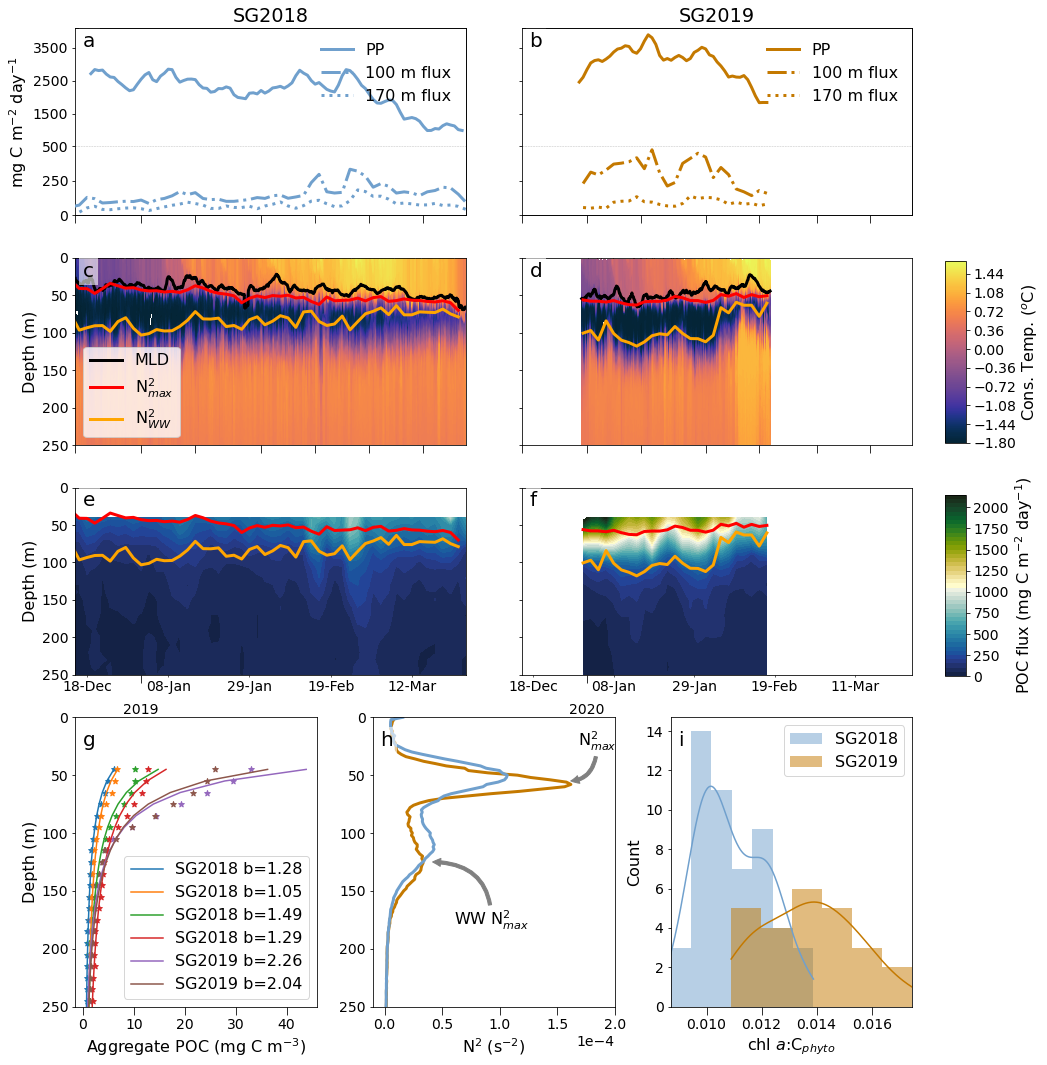

In [45]:
# NEW


import matplotlib 
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'xtick.major.size': 8})


cmap = cmo.thermal

import matplotlib.gridspec as gridspec
import datetime

fig=plt.figure(figsize=[15,18],constrained_layout=True)
gs = gridspec.GridSpec(4, 6,hspace=0.2,wspace=0.6,height_ratios=[0.22,0.22,0.22,0.34])

ax1 = fig.add_subplot(gs[0,:3])
ax2 = fig.add_subplot(gs[1,:3])
ax3 = fig.add_subplot(gs[2,:3])

ax4 = fig.add_subplot(gs[0,3:])
ax5 = fig.add_subplot(gs[1,3:])
ax6 = fig.add_subplot(gs[2,3:])

lns1=ax1.plot(npp643.time,(npp643.cbpm_int_glider.rolling(time=4).mean()).values,c=lightblue,label='PP',lw=3)
ax1.set_yticks([500,1500,2500,3500])
ax1.set_ylim(-1600,4100)
ax1b=ax1.twinx()
lns2=ax1b.plot(sg643.index,sg643.large_particle_flux[10,:],c=lightblue,label='100 m flux',lw=3,linestyle='dashdot')
lns3=ax1b.plot(sg643.index,sg643.large_particle_flux[17,:],c=lightblue,label='170 m flux',lw=3,linestyle='dotted')

ax1b.set_yticks([0,250])
ax1b.set_ylim(0,1350)
ax1b.yaxis.tick_left()
ax1b.spines["left"].set_visible(False)
lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax1b.legend(lns, labs,loc='upper right',frameon=False)
ax1b.set_xticklabels('')
ax1.set_xlim([datetime.date(2018, 12, 15), datetime.date(2019, 3, 26)])
ax1b.set_xlim([datetime.date(2018, 12, 15), datetime.date(2019, 3, 26)])
ax1.axhline(500,lw=0.5,c='grey',linestyle='--',alpha=0.5)


xx,yy=np.meshgrid(time643,np.arange(0,400,2)[:-1])
levels = np.arange(-1.8,1.7,0.02)
cs=ax2.contourf(xx,yy,ct_z643.iloc[:,:].interpolate(lim=5),levels=levels,cmap=cmap)
ax2.plot(time643[:],mld_smooth643.iloc[:],c='k',lw=3,label='MLD')
ax2.set_ylim(250,0)

ax2.set_xticklabels('')
ax2.set_xlim([datetime.date(2018, 12, 15), datetime.date(2019, 3, 26)])
ax2.plot(n2_smoothed643.index,n2_smoothed643.n2max,lw=3,c='r',label='N$^2_{max}$')
ax2.plot(n2_smoothed643.index,n2_smoothed643.n2second,lw=3,c='orange',label = 'N$^2_{WW}$')
ax2.legend()
xx,yy=np.meshgrid(sg643.index,np.arange(0,390,10))
levels=np.arange(0,2200,50)
ax3.plot(n2_smoothed643.index,n2_smoothed643.n2max,lw=3,c='r')
ax3.contourf(xx,yy,sg643.large_particle_flux,cmap=cmo.delta,levels=levels)
levels=np.arange(0,2200,200)
# ax3.contour(xx,yy,sg643.large_particle_flux,levels=levels,colors='white')
# ax3.axhline(100,c='Grey',lw=3,ls='dashdot',label='100 m')
# ax3.axhline(170,c='Grey',lw=3,ls='dotted',label='170 m')
ax3.set_ylim(250,0)
ax3.set_xlim([datetime.date(2018, 12, 15), datetime.date(2019, 3, 26)])

ax3.plot(n2_smoothed643.index,n2_smoothed643.n2second,lw=3,c='orange')

lns4=ax4.plot(npp640.time[16:],(npp640.cbpm_int_sat.rolling(time=4).mean())[16:].values,c=orange,label='PP',lw=3)
ax4.set_yticks([500,1500,2500,3500])
ax4.set_ylim(-1600,4100)
ax4b=ax4.twinx()
lns5=ax4b.plot(sg640.index[36:],sg640.large_particle_flux[10,36:],c=orange,label='100 m flux',lw=3,linestyle='dashdot')
lns6=ax4b.plot(sg640.index[36:],sg640.large_particle_flux[17,36:],c=orange,label='170 m flux',lw=3,linestyle='dotted')

ax4b.set_yticks([0,250])
ax4b.set_ylim(0,1350)
ax4b.yaxis.tick_left()
ax4b.spines["left"].set_visible(False)
lns0 = lns4+lns5+lns6
labs = [l.get_label() for l in lns0]
ax4b.legend(lns0, labs,loc='upper right',frameon=False)
ax4.set_yticklabels('')
ax4b.set_yticklabels('')
ax4.set_xticklabels('')
ax4b.set_xticklabels('')
ax4.set_xlim([datetime.date(2019, 12, 15), datetime.date(2020, 3, 26)])
ax4b.set_xlim([datetime.date(2019, 12, 15), datetime.date(2020, 3, 26)])
ax4.axhline(500,lw=0.5,c='grey',linestyle='--',alpha=0.5)


xx,yy=np.meshgrid(time640[671:],np.arange(0,400,2)[:-1])
levels = np.arange(-1.8,1.7,0.02)
ax5.contourf(xx,yy,ct_z640.iloc[:,671:].interpolate(lim=5)+0.02,levels=levels,cmap=cmap)   # check CTD for most likely offset in T here
ax5.plot(time640[671:],mld_smooth640.iloc[671:],c='k',lw=3)
ax5.set_ylim(250,0)

ax5.set_xticklabels('')
ax5.set_yticklabels('')
ax5.set_xlim([datetime.date(2019, 12, 15), datetime.date(2020, 3, 26)])
cbaxes = fig.add_axes([0.93, 0.56, 0.02, 0.14])
cbar=plt.colorbar(cs,cax=cbaxes)
cbar.set_label('Cons. Temp. ($^o$C)')
ax5.plot(n2_smoothed640.index[:],n2_smoothed640.n2max[:],lw=3,c='r')
ax5.plot(n2_smoothed640.index[:],n2_smoothed640.n2second[:],lw=3,c='orange')

xx,yy=np.meshgrid(sg640.index[36:],np.arange(0,390,10))
levels=np.arange(0,2200,50)
cs2=ax6.contourf(xx,yy,sg640.large_particle_flux[:,36:],cmap=cmo.delta,levels=levels)
levels=np.arange(0,2200,200)
# ax6.contour(xx,yy,sg640.large_particle_flux[:,36:],levels=levels,colors='white')
ax6.plot(n2_smoothed640.index,n2_smoothed640.n2second,lw=3,c='orange')
ax6.plot(n2_smoothed640.index[:],n2_smoothed640.n2max[:],lw=3,c='r')

# ax6.axhline(100,c='Grey',lw=3,ls='dashdot')
# ax6.axhline(170,c='Grey',lw=3,ls='dotted')
ax6.set_ylim(250,0)
ax6.set_xlim([datetime.date(2019, 12, 15), datetime.date(2020, 3, 26)])
ax6.set_yticklabels('')
cbaxes2 = fig.add_axes([0.93, 0.38, 0.02, 0.14])
cbar2 = plt.colorbar(cs2,cax=cbaxes2)

cbar2.set_label('POC flux (mg C m$^{-2}$ day$^{-1}$)')

import matplotlib.dates as mdates
for axes in [ax3,ax6]:  
    axes.xaxis.set_major_locator(mdates.YearLocator())
    axes.xaxis.set_minor_locator(mdates.DayLocator(interval=21))
    axes.xaxis.set_major_formatter(mdates.DateFormatter("\n%Y"))
    axes.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%b"))
    

ax1.set_ylabel('mg C m$^{-2}$ day$^{-1}$')  # check units
ax2.set_ylabel('Depth (m)')
ax3.set_ylabel('Depth (m)')


#######################################################################
#Add to far right column
ax7 = fig.add_subplot(gs[3,0:2])
ax8 = fig.add_subplot(gs[3,2:4])
ax9 = fig.add_subplot(gs[3,4:])

XX,YY = np.meshgrid(time640,np.arange(0,400,2)[:-1])
YY= np.nanmean(np.array(YY),1)

N2vmean640 = (np.nanmean(np.abs(np.array(n2_z640.iloc[:,671:])),1))
N2vstd640 = (np.nanstd(np.abs(np.array(n2_z640.iloc[:,671:])),1))


N2vmean643 = (np.nanmean(np.abs(np.array(n2_z643)),1))
N2vstd643= (np.nanstd(np.abs(np.array(n2_z643)),1))

ax8.plot(N2vmean640,YY,color=orange,label='sg640',lw=3)
ax8.plot(N2vmean643,YY,color=lightblue,label='sg643',lw=3)

ax8.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
ax8.set_ylim(250,0)
ax8.set_xlim(-0.1e-4,2e-4)
ax8.set_xlabel('N$^2$ (s$^{-2}$)')
# ax8.set_ylabel('Depth (m)')



ax8.annotate("N$^2_{max}$",
            xy=(1.6e-4,55), xycoords='data',
            xytext=(1.68e-4,25), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="angle3",
                            color='grey'
                           ),
            )


ax8.annotate("WW N$^2_{max}$",
            xy=(0.4e-4,125), xycoords='data',
            xytext=(0.6e-4,180), textcoords='data',
            arrowprops=dict(arrowstyle="simple",
                            connectionstyle="angle3",
                            color='grey'
                           ),
            )



sns.histplot(data=n2_smoothed643.CI,color=lightblue,kde=True,ax=ax9,edgecolor=None,label='SG2018')
sns.histplot(data=n2_smoothed640.CI,color=orange,kde=True,ax=ax9,edgecolor=None,label='SG2019')
ax9.legend()
ax9.set_xlim(n2_smoothed643.CI.min(),n2_smoothed640.CI.max())
ax9.set_xlabel('chl $\it{a}$:C$_{phyto}$')



#############################


bpoc643=[]
bpoc640=[]

for i in [1,2,5,7]:
    max_spike_nomask = np.array(dfR643_poc.iloc[i].max_spike)
    depth_nomask = np.array(dfR643_poc.iloc[i].depth)

    max_spike = np.array(dfR643_poc.iloc[i].max_spike)
    depth = np.array(dfR643_poc.iloc[i].depth)

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X643=max_spike[mask]
    Y=depth[mask]

    ax7.scatter((max_spike_nomask),(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X643,)
    bpoc643.append(popt_log[1])
    ax7.plot((ydatafit_log),Y,label='SG2018 b={}'.format(popt_log[1].round(2)))

    ax7.legend(loc='lower left')

    
for i in [2,5]:
    max_spike_nomask = np.array(dfR640_poc.iloc[i].max_spike)+0
    depth_nomask = np.array(dfR640_poc.iloc[i].depth)

    max_spike = np.array(dfR640_poc.iloc[i].max_spike)+0
    depth = np.array(dfR640_poc.iloc[i].depth)

    mask = ~np.isnan(max_spike)&~np.isnan(depth)
    X640=max_spike[mask]
    Y=depth[mask]

    ax7.scatter((max_spike_nomask),(depth_nomask),marker='*')

    popt_log, pcov_log, ydatafit_log=martins_curve_log(Y,X640,)
    bpoc640.append(popt_log[1])
    ax7.plot((ydatafit_log),Y,label='SG2019 b={}'.format(popt_log[1].round(2)))

    ax7.legend()
    ax7.set_ylim(250,0)

    
ax7.set_ylabel('Depth (m)')

bpoc643=np.array(bpoc643)
bpoc640=np.array(bpoc640)

ax7.set_xlabel('Aggregate POC (mg C m$^{-3}$)')


################################

ax1.text(0.02,0.9,'a',transform=ax1.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax2.text(0.02,0.9,'c',transform=ax2.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax3.text(0.02,0.9,'e',transform=ax3.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax4.text(0.02,0.9,'b',transform=ax4.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax5.text(0.02,0.9,'d',transform=ax5.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax6.text(0.02,0.9,'f',transform=ax6.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax7.text(0.03,0.9,'g',transform=ax7.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax8.text(0.03,0.9,'h',transform=ax8.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax9.text(0.03,0.9,'i',transform=ax9.transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))

ax1.set_title('SG2018')
ax4.set_title('SG2019')


plt.savefig('../results/figures/figure3_3102021.png',dpi=300, bbox_inches='tight')

## Add supplementary figures demonstrating 
i) Export efficiencies to 100 m and 170 m   
ii) Export flux at different depths  
iii) Difference between export at ML, WW and 100 m   

In [46]:
export640_sub=sg640.large_particle_flux[:,36:]
flux_base_ww640 = np.ndarray([25])
for i in range(25):
    
    ind=np.abs(export640_sub.columns-n2_smoothed640.n2second[i]).argmin()
    flux_base_ww640[i] = export640_sub[ind,i]
    
flux_base_ml640 = np.ndarray([25])
for i in range(25):
    
    ind=np.abs(export640_sub.columns-n2_smoothed640.n2max[i]).argmin()
    flux_base_ml640[i] = export640_sub[ind,i]
    
flux_base_ww643 = np.ndarray([51])
for i in range(51):
    ind=np.abs(sg643.columns-n2_smoothed643.n2second[i]).argmin()
#     print(ind)
    flux_base_ww643[i] = sg643.large_particle_flux[ind,i]
    
flux_base_ml643 = np.ndarray([51])
for i in range(51):
    ind=np.abs(sg643.columns-n2_smoothed643.n2max[i]).argmin()
    flux_base_ml643[i] = sg643.large_particle_flux[ind,i]

In [47]:
# export efficiency PP to 100 - 2 day lag

ee643_100=pd.Series(np.repeat(export643.POC_100,2)[2:-1]).shift(-2).values/npp643.cbpm_int_glider.values
ee640_100 = pd.Series(np.repeat(export640.POC_100,2))[:].shift(-2).values/npp640.cbpm_int_sat[16:].values

# export efficiency PP to 170 - 2 day lag

ee643_170=pd.Series(np.repeat(export643.POC_170,2)[2:-1]).shift(-2).values/npp643.cbpm_int_glider.values
ee640_170 = pd.Series(np.repeat(export640.POC_170,2))[:].shift(-2).values/npp640.cbpm_int_sat[16:].values


te643_170=pd.Series(np.repeat(export643.POC_170,2)[2:-1]).shift(-2).values/pd.Series(np.repeat(export643.POC_100,2)[2:-1]).shift(0).values
te640_170 = pd.Series(np.repeat(export640.POC_170,2))[:].shift(-2).values/pd.Series(np.repeat(export640.POC_100,2))[:].shift(0).values


In [48]:
print(np.nanmean(te643_170))
print(np.nanmean(te640_170))

0.5030402532319651
0.3100527707085646


In [49]:
print(np.nanmean(ee643_170))
print(np.nanmean(ee640_170))

0.038686583294428395
0.030342076198955455


In [50]:
print(np.nanmean(ee643_100))
print(np.nanmean(ee640_100))

0.07949102218329761
0.09980539830013607


0.3100527707085646
0.5030402532319651
0.0930765104852002
0.10362766214883862
0.09980539830013607
0.07949102218329761


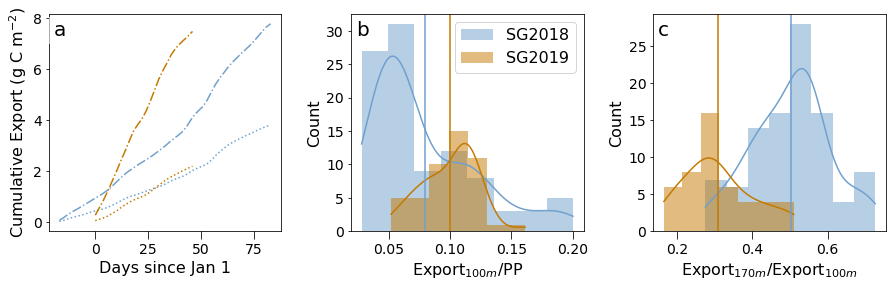

In [51]:
fig,ax=plt.subplots(1,3,figsize=[15,4])
plt.subplots_adjust(wspace=0.3)

# ax[0].plot(cumtrapz(flux_base_ml643)/1000)
# ax[0].plot(cumtrapz(flux_base_ml640)/1000)

from scipy.integrate import cumtrapz

ax[0].plot(export643.days_since[:-1],cumtrapz(export643.POC_170)/1000,c=lightblue,ls='dotted',)
ax[0].plot(export640.days_since[:-1],cumtrapz(export640.POC_170)/1000,c=orange,ls='dotted',)


# ax[0].plot(export643.days_since[:-2],cumtrapz(flux_base_ww643)/1000,c=lightblue,ls='dashed')   # WW layer and 100 m are similar 
# ax[0].plot(export640.days_since[:-1],cumtrapz(flux_base_ww640)/1000,c=orange,ls='dashed')

ax[0].plot(export643.days_since[:-1],cumtrapz(export643.POC_100)/1000,c=lightblue,ls='dashdot')
ax[0].plot(export640.days_since[:-1],cumtrapz(export640.POC_100)/1000,c=orange,ls='dashdot')

# ax[0].text(export643.days_since[-12],(cumtrapz(export643.POC_100)/1000)[-15],'100 m',transform=ax[0].transData,fontsize=14,color=lightblue,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
# ax[0].text(export643.days_since[-12],(cumtrapz(flux_base_ww643)/1000)[-5],' WW',transform=ax[0].transData,fontsize=14,color=lightblue,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))


# ax[0].text(export640.days_since[-8],(cumtrapz(export640.POC_100)/1000)[-5],'100 m',transform=ax[0].transData,fontsize=14,color=orange,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
# ax[0].text(export640.days_since[-12],(cumtrapz(flux_base_ww640)/1000)[-5],' WW',transform=ax[0].transData,fontsize=14,color=orange,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))

ax[0].set_ylabel('Cumulative Export (g C m$^{-2}$)')
ax[0].set_xlabel('Days since Jan 1')

# ax[0].plot(cumtrapz(export643.POC_170)/1000,c='tab:blue',ls='dotted',lw=3)
# ax[0].plot(cumtrapz(export640.POC_170)/1000,c='tab:orange',ls='dotted',lw=3)


sns.histplot(data=ee643_100,color=lightblue,kde=True,edgecolor=None,ax=ax[1],label='SG2018')
sns.histplot(data=ee640_100,color=orange,kde=True,edgecolor=None,ax=ax[1],label='SG2019')
ax[1].legend()
ax[1].set_xlabel('Export$_{100 m}$/PP')

sns.histplot(data=te643_170,color=lightblue,kde=True,edgecolor=None,ax=ax[2])
sns.histplot(data=te640_170,color=orange,kde=True,edgecolor=None,ax=ax[2])
ax[2].set_xlabel('Export$_{170 m}$/Export$_{100 m}$')

ax[2].axvline(np.nanmean(te640_170),color=orange)
ax[2].axvline(np.nanmean(te643_170),color=lightblue)

ax[1].axvline(np.nanmean(ee640_100),color=orange)
ax[1].axvline(np.nanmean(ee643_100),color=lightblue)

print(np.nanmean(te640_170))
print(np.nanmean(te643_170))

print(np.nanstd(te640_170))
print(np.nanstd(te643_170))

print(np.nanmean(ee640_100))
print(np.nanmean(ee643_100))

ax[0].text(0.02,0.9,'a',transform=ax[0].transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax[1].text(0.02,0.9,'b',transform=ax[1].transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))
ax[2].text(0.02,0.9,'c',transform=ax[2].transAxes,fontsize=20,bbox=dict(facecolor='white', edgecolor='None',alpha=0.6))

plt.savefig('../results/figures/S8_sup_export.png',dpi=300,bbox_inches='tight')